# Coiled Basic Workflows with NASA Earthdata
## Local loading of data with remote processing of data


### Summary

This notebook processes Earthdata data using the following workflow

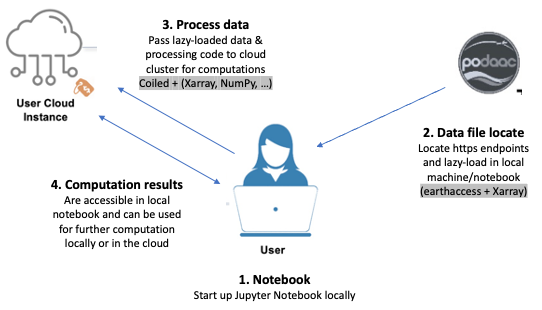

Specifically, the notebook will work with gridded global MUR 1 km sea surface temperature (SST) data to:
1. Log into Earthdata using earthaccess and get local access to 50 MUR 1 km files with Xarray's open_mfdataset().
2. Start a remote cluster using Coiled.
3. Compute the spatial mean over two different regions of the globe for the 50 files on the remote cluster. Then plot the resulting time series.

### earthaccess library requirements

This notebook requires a fix to the earthaccess library which is not part of the standard distribution: https://github.com/nsidc/earthaccess/pull/276

It can be installed with:
```
pip uninstall -y earthaccess
pip install git+https://github.com/jrbourbeau/earthaccess.git@include-store
```

In [1]:
# Access libraries
import s3fs
import requests
import earthaccess

# Parallel computing libraries
import coiled

# Data analysis libraries
import xarray as xr

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Locate MUR SST files on PO.DAAC using `earthaccess` and open using `Xarray`

**Login to Earthdata**

In [2]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using .netrc file for EDL


**Locate endpoints for first 50 files (will be https endpoints since working locally)**

In [4]:
results = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    cloud_hosted=True,
    #bounding_box=bounding_box,
    #temporal=("2021-04-01", "2021-05-6"),
    count=50,
    )

Granules found: 7749


**Open with `Xarray`**

In [5]:
%%time

# Create file-like objects to pass to xarray
fileobjs = earthaccess.open(results)

 Opening 50 granules, approx size: 16.05 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/50 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 302 ms, sys: 76.7 ms, total: 379 ms
Wall time: 4.66 s


In [6]:
%%time

# Open/merge all files as a single dataset:
murdata = xr.open_mfdataset(fileobjs, chunks={'time':1, 'lat':6000, 'lon':6000})

CPU times: user 6.42 s, sys: 1.81 s, total: 8.22 s
Wall time: 2min 3s


In [7]:
murdata

<xarray.Dataset>
Dimensions:           (time: 50, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-07-2...
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 6000, 6000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 6000, 6000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 6000, 6000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 6000, 6000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

## 2. Create a remote cluster using `Coiled`

In [10]:
%%time

cluster = coiled.Cluster(
    n_workers=10, 
    account="podaac-science", 
    region="us-west-2", 
    #worker_memory="64 GiB",
    #name='podaac-science-c0a69b8d-e'
    ) 
client = cluster.get_client()

Output()

Package - appnope, appnope~=0.1.2 has no install candidate for linux-64 on pkgs/main

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                            ╷                                                                     │
│   Package                  │ Note                                                                │
│ ╶──────────────────────────┼───────────────────────────────────────────────────────────────────╴ │
│   coiled_local_basic_tests │ Source wheel built from                                             │
│                            │ /Users/henze/Desktop/PODAAC/projects/cloud_computing/coiled/basic   │
│                            │ _tests                                                              │
│   earthaccess              │ Wheel built from                                                    │
│                            │ git+https://github.com/jrbourbeau/earthaccess.git@cd260a51873d0e4   │
│                            │ 43f9973e0d2aba9fd7aa82680                                           │
│                            ╵                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│            ╷                                                                         ╷           │
│   Package  │ Error                                                                   │ Risk      │
│ ╶──────────┼─────────────────────────────────────────────────────────────────────────┼─────────╴ │
│   appnope  │ appnope~=0.1.2 has no install candidate for linux-64 on pkgs/main       │ Warning   │
│            ╵                                                                         ╵           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

CPU times: user 4.78 s, sys: 472 ms, total: 5.25 s
Wall time: 1min 21s


In [5]:
#client  # Un-comment this line to see client specs.

## 3. Run computations
Compute the spatial mean over two different regions of the globe for the 50 files on the remote cluster. Then plot the resulting time series.

In [9]:
## Bounding boxes for two regions to perform computations over

# Sub-tropical western Atlantic region:
latbnds1 = (20, 30)
lonbnds1 = (-82, -72)

# Mid-latitude eastern Pacific region:
latbnds2 = (45, 55)
lonbnds2 = (-137, -127)

In [8]:
def regional_spatial_mean(sstdata, latbnds, lonbnds):
    """
    Function meant to be run with dask.
    Takes an xarray.DataArray (with dimensions lat, lon), subsets spatially using
    input 2-tuples, returns mean over the subsetted region.
    """
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.mean(dim=['lat','lon'], skipna=True) # mean
    return future_result.load()

In [19]:
%%time

# Computations
region1_mean_sst = regional_spatial_mean(murdata['analysed_sst'], latbnds1, lonbnds1)
region2_mean_sst = regional_spatial_mean(murdata['analysed_sst'], latbnds2, lonbnds2)

In [4]:
cluster.shutdown()

Text(0, 0.5, 'SST [K]')

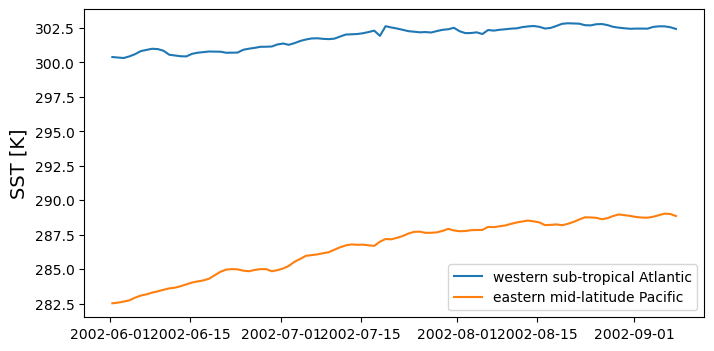

In [39]:
## Plot results

fig = plt.figure(figsize=(8, 4))
axes = plt.axes()

axes.plot(region1_mean_sst['time'], region1_mean_sst.values, label='western sub-tropical Atlantic')
axes.plot(region2_mean_sst['time'], region2_mean_sst.values, label='eastern mid-latitude Pacific')

axes.legend()
axes.set_ylabel('SST [K]', fontsize=14)